In [1]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import numpy as np

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
torch.__version__

'1.9.1'

In [4]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3), value=(125,122,114), inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [7]:
# Training
def train(epoch, net, criterion, trainloader,scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    beta = 1
    cutmix_prob = 1

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        r = np.random.rand(1)
        
        if beta > 0 and r < cutmix_prob:
            # generate mixed sample
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(inputs.size()[0]).cuda()
            target_a = targets
            target_b = targets[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
            inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
            # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
            # compute output
            outputs = net(inputs)
            loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
        else:
            # compute output
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
            print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

In [12]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            #inputs.requires_grad = True
            outputs = net(inputs)

            loss= criterion(outputs, targets)
            #R = reg(inputs, outputs)   # Jacobian regularization
            #loss = loss_super + lambda_JR*R # full loss
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [13]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [14]:
# defining resnet models
from dropblock import DropBlock2D, LinearScheduler

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, drop_prob=0.9, block_size=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropblock = LinearScheduler(
            DropBlock2D(drop_prob=drop_prob, block_size=block_size),
            start_value=0.,
            stop_value=drop_prob,
            nr_steps=5e3
        )
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        self.dropblock.step() 
        out = F.relu(self.bn1(self.conv1(x)))
        #out = self.layer1(out)
        #out = self.layer2(out)
        out = self.dropblock(self.layer1(out))
        out = self.dropblock(self.layer2(out))
        
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [15]:
# main body
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 5e-4
}

train_loss_list = []
train_acc_list  = []
test_loss_list  = []
test_acc_list  = []


net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
#print(scheduler)
for epoch in range(0, 200):
    # normal - train, jaco- jaco_train, mma - mma_train
    train_loss, train_acc = train(epoch, net, criterion, trainloader,scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    


Epoch: 0


<ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-6-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more detai

iteration :  50, loss : 2.1493, accuracy : 21.42
iteration : 100, loss : 2.1186, accuracy : 22.96
iteration : 150, loss : 2.0857, accuracy : 24.61
iteration : 200, loss : 2.0518, accuracy : 25.96
iteration : 250, loss : 2.0286, accuracy : 27.06
iteration : 300, loss : 2.0034, accuracy : 27.84
iteration : 350, loss : 1.9811, accuracy : 28.71
Epoch :   0, training loss : 1.9632, training accuracy : 29.39, test loss : 1.5192, test accuracy : 45.71

Epoch: 1
iteration :  50, loss : 1.8836, accuracy : 33.12
iteration : 100, loss : 1.8561, accuracy : 33.67
iteration : 150, loss : 1.8333, accuracy : 34.55
iteration : 200, loss : 1.8324, accuracy : 34.66
iteration : 250, loss : 1.8113, accuracy : 35.37
iteration : 300, loss : 1.8029, accuracy : 35.87
iteration : 350, loss : 1.8023, accuracy : 36.03
Epoch :   1, training loss : 1.8012, training accuracy : 36.07, test loss : 1.2856, test accuracy : 53.17

Epoch: 2
iteration :  50, loss : 1.7431, accuracy : 38.64
iteration : 100, loss : 1.7114, a

iteration :  50, loss : 1.2860, accuracy : 53.94
iteration : 100, loss : 1.2886, accuracy : 54.48
iteration : 150, loss : 1.3000, accuracy : 54.02
iteration : 200, loss : 1.3015, accuracy : 53.91
iteration : 250, loss : 1.3077, accuracy : 53.73
iteration : 300, loss : 1.3162, accuracy : 53.54
iteration : 350, loss : 1.3049, accuracy : 53.90
Epoch :  18, training loss : 1.2966, training accuracy : 54.22, test loss : 0.7847, test accuracy : 72.49

Epoch: 19
iteration :  50, loss : 1.2551, accuracy : 56.42
iteration : 100, loss : 1.2501, accuracy : 56.44
iteration : 150, loss : 1.2757, accuracy : 55.56
iteration : 200, loss : 1.2799, accuracy : 55.31
iteration : 250, loss : 1.2981, accuracy : 54.87
iteration : 300, loss : 1.2853, accuracy : 55.20
iteration : 350, loss : 1.2949, accuracy : 54.70
Epoch :  19, training loss : 1.2917, training accuracy : 54.77, test loss : 0.8446, test accuracy : 70.63

Epoch: 20
iteration :  50, loss : 1.3421, accuracy : 53.08
iteration : 100, loss : 1.2887,

iteration :  50, loss : 1.0893, accuracy : 60.50
iteration : 100, loss : 1.0818, accuracy : 61.24
iteration : 150, loss : 1.0507, accuracy : 62.77
iteration : 200, loss : 1.0498, accuracy : 62.84
iteration : 250, loss : 1.0526, accuracy : 62.67
iteration : 300, loss : 1.0793, accuracy : 61.76
iteration : 350, loss : 1.0706, accuracy : 62.11
Epoch :  36, training loss : 1.0708, training accuracy : 62.09, test loss : 0.7328, test accuracy : 74.72

Epoch: 37
iteration :  50, loss : 1.0084, accuracy : 64.66
iteration : 100, loss : 1.0112, accuracy : 64.39
iteration : 150, loss : 1.0285, accuracy : 63.71
iteration : 200, loss : 1.0421, accuracy : 63.15
iteration : 250, loss : 1.0519, accuracy : 62.79
iteration : 300, loss : 1.0587, accuracy : 62.55
iteration : 350, loss : 1.0494, accuracy : 62.85
Epoch :  37, training loss : 1.0559, training accuracy : 62.66, test loss : 0.7235, test accuracy : 75.09

Epoch: 38
iteration :  50, loss : 1.1370, accuracy : 59.81
iteration : 100, loss : 1.0672,

iteration :  50, loss : 0.9288, accuracy : 67.66
iteration : 100, loss : 1.0043, accuracy : 64.76
iteration : 150, loss : 0.9734, accuracy : 65.84
iteration : 200, loss : 0.9626, accuracy : 66.19
iteration : 250, loss : 0.9557, accuracy : 66.47
iteration : 300, loss : 0.9623, accuracy : 66.11
iteration : 350, loss : 0.9713, accuracy : 65.79
Epoch :  54, training loss : 0.9672, training accuracy : 65.95, test loss : 0.5889, test accuracy : 80.16

Epoch: 55
iteration :  50, loss : 0.9019, accuracy : 67.45
iteration : 100, loss : 0.9135, accuracy : 67.52
iteration : 150, loss : 0.9571, accuracy : 65.97
iteration : 200, loss : 0.9438, accuracy : 66.54
iteration : 250, loss : 0.9444, accuracy : 66.60
iteration : 300, loss : 0.9432, accuracy : 66.74
iteration : 350, loss : 0.9487, accuracy : 66.58
Epoch :  55, training loss : 0.9503, training accuracy : 66.53, test loss : 0.5318, test accuracy : 81.24

Epoch: 56
iteration :  50, loss : 0.9891, accuracy : 64.50
iteration : 100, loss : 0.9557,

iteration :  50, loss : 0.8810, accuracy : 68.72
iteration : 100, loss : 0.9072, accuracy : 67.93
iteration : 150, loss : 0.8863, accuracy : 68.65
iteration : 200, loss : 0.8788, accuracy : 68.96
iteration : 250, loss : 0.9012, accuracy : 68.14
iteration : 300, loss : 0.8937, accuracy : 68.41
iteration : 350, loss : 0.9001, accuracy : 68.28
Epoch :  72, training loss : 0.9035, training accuracy : 68.21, test loss : 0.4925, test accuracy : 83.56

Epoch: 73
iteration :  50, loss : 0.8461, accuracy : 70.06
iteration : 100, loss : 0.9143, accuracy : 67.83
iteration : 150, loss : 0.9072, accuracy : 67.98
iteration : 200, loss : 0.9105, accuracy : 67.78
iteration : 250, loss : 0.9018, accuracy : 68.09
iteration : 300, loss : 0.8986, accuracy : 68.21
iteration : 350, loss : 0.8855, accuracy : 68.69
Epoch :  73, training loss : 0.8951, training accuracy : 68.39, test loss : 0.6112, test accuracy : 79.54

Epoch: 74
iteration :  50, loss : 0.8291, accuracy : 70.61
iteration : 100, loss : 0.8616,

iteration :  50, loss : 0.8917, accuracy : 68.77
iteration : 100, loss : 0.8938, accuracy : 68.80
iteration : 150, loss : 0.8783, accuracy : 69.19
iteration : 200, loss : 0.8733, accuracy : 69.20
iteration : 250, loss : 0.8677, accuracy : 69.33
iteration : 300, loss : 0.8616, accuracy : 69.51
iteration : 350, loss : 0.8502, accuracy : 69.88
Epoch :  90, training loss : 0.8458, training accuracy : 70.06, test loss : 0.5293, test accuracy : 82.58

Epoch: 91
iteration :  50, loss : 0.8287, accuracy : 70.00
iteration : 100, loss : 0.8212, accuracy : 70.66
iteration : 150, loss : 0.7914, accuracy : 71.86
iteration : 200, loss : 0.7921, accuracy : 71.96
iteration : 250, loss : 0.8025, accuracy : 71.60
iteration : 300, loss : 0.7934, accuracy : 71.93
iteration : 350, loss : 0.7998, accuracy : 71.70
Epoch :  91, training loss : 0.8026, training accuracy : 71.65, test loss : 0.5215, test accuracy : 83.12

Epoch: 92
iteration :  50, loss : 0.8295, accuracy : 70.81
iteration : 100, loss : 0.8184,

iteration :  50, loss : 0.8352, accuracy : 70.70
iteration : 100, loss : 0.7907, accuracy : 71.92
iteration : 150, loss : 0.7849, accuracy : 72.27
iteration : 200, loss : 0.7914, accuracy : 72.17
iteration : 250, loss : 0.7935, accuracy : 72.15
iteration : 300, loss : 0.7885, accuracy : 72.45
iteration : 350, loss : 0.7820, accuracy : 72.67
Epoch : 108, training loss : 0.7784, training accuracy : 72.75, test loss : 0.4273, test accuracy : 85.49

Epoch: 109
iteration :  50, loss : 0.8207, accuracy : 71.25
iteration : 100, loss : 0.7979, accuracy : 72.05
iteration : 150, loss : 0.7903, accuracy : 72.15
iteration : 200, loss : 0.7862, accuracy : 72.22
iteration : 250, loss : 0.7807, accuracy : 72.55
iteration : 300, loss : 0.7815, accuracy : 72.58
iteration : 350, loss : 0.7804, accuracy : 72.58
Epoch : 109, training loss : 0.7702, training accuracy : 72.94, test loss : 0.4141, test accuracy : 85.94

Epoch: 110
iteration :  50, loss : 0.8026, accuracy : 71.97
iteration : 100, loss : 0.765

iteration :  50, loss : 0.7332, accuracy : 74.11
iteration : 100, loss : 0.7548, accuracy : 73.59
iteration : 150, loss : 0.7445, accuracy : 73.94
iteration : 200, loss : 0.7267, accuracy : 74.41
iteration : 250, loss : 0.7319, accuracy : 74.20
iteration : 300, loss : 0.7371, accuracy : 73.92
iteration : 350, loss : 0.7321, accuracy : 73.99
Epoch : 126, training loss : 0.7271, training accuracy : 74.18, test loss : 0.3817, test accuracy : 87.49

Epoch: 127
iteration :  50, loss : 0.6612, accuracy : 76.83
iteration : 100, loss : 0.7231, accuracy : 74.59
iteration : 150, loss : 0.7207, accuracy : 74.55
iteration : 200, loss : 0.7181, accuracy : 74.66
iteration : 250, loss : 0.7331, accuracy : 74.08
iteration : 300, loss : 0.7296, accuracy : 74.23
iteration : 350, loss : 0.7294, accuracy : 74.19
Epoch : 127, training loss : 0.7276, training accuracy : 74.28, test loss : 0.3311, test accuracy : 89.17

Epoch: 128
iteration :  50, loss : 0.6479, accuracy : 77.25
iteration : 100, loss : 0.686

iteration :  50, loss : 0.7109, accuracy : 74.86
iteration : 100, loss : 0.7079, accuracy : 75.09
iteration : 150, loss : 0.6771, accuracy : 76.29
iteration : 200, loss : 0.6676, accuracy : 76.73
iteration : 250, loss : 0.6607, accuracy : 76.92
iteration : 300, loss : 0.6590, accuracy : 76.89
iteration : 350, loss : 0.6506, accuracy : 77.21
Epoch : 144, training loss : 0.6445, training accuracy : 77.35, test loss : 0.3512, test accuracy : 88.30

Epoch: 145
iteration :  50, loss : 0.6544, accuracy : 76.77
iteration : 100, loss : 0.6574, accuracy : 76.49
iteration : 150, loss : 0.6540, accuracy : 76.68
iteration : 200, loss : 0.6472, accuracy : 77.05
iteration : 250, loss : 0.6423, accuracy : 77.16
iteration : 300, loss : 0.6423, accuracy : 77.26
iteration : 350, loss : 0.6442, accuracy : 77.17
Epoch : 145, training loss : 0.6408, training accuracy : 77.23, test loss : 0.3255, test accuracy : 89.10

Epoch: 146
iteration :  50, loss : 0.6250, accuracy : 78.25
iteration : 100, loss : 0.636

iteration :  50, loss : 0.6009, accuracy : 78.94
iteration : 100, loss : 0.5804, accuracy : 79.55
iteration : 150, loss : 0.5800, accuracy : 79.66
iteration : 200, loss : 0.5900, accuracy : 79.36
iteration : 250, loss : 0.5993, accuracy : 78.87
iteration : 300, loss : 0.6050, accuracy : 78.59
iteration : 350, loss : 0.6049, accuracy : 78.61
Epoch : 162, training loss : 0.5985, training accuracy : 78.77, test loss : 0.3169, test accuracy : 89.48

Epoch: 163
iteration :  50, loss : 0.5580, accuracy : 79.95
iteration : 100, loss : 0.5932, accuracy : 79.08
iteration : 150, loss : 0.5939, accuracy : 79.07
iteration : 200, loss : 0.5877, accuracy : 79.41
iteration : 250, loss : 0.5976, accuracy : 79.02
iteration : 300, loss : 0.6140, accuracy : 78.36
iteration : 350, loss : 0.6149, accuracy : 78.27
Epoch : 163, training loss : 0.6107, training accuracy : 78.41, test loss : 0.2656, test accuracy : 91.22

Epoch: 164
iteration :  50, loss : 0.5041, accuracy : 82.06
iteration : 100, loss : 0.545

iteration :  50, loss : 0.5004, accuracy : 82.19
iteration : 100, loss : 0.5429, accuracy : 81.10
iteration : 150, loss : 0.5467, accuracy : 80.83
iteration : 200, loss : 0.5457, accuracy : 80.91
iteration : 250, loss : 0.5336, accuracy : 81.28
iteration : 300, loss : 0.5366, accuracy : 81.20
iteration : 350, loss : 0.5374, accuracy : 81.16
Epoch : 180, training loss : 0.5323, training accuracy : 81.31, test loss : 0.2597, test accuracy : 91.26

Epoch: 181
iteration :  50, loss : 0.5335, accuracy : 81.41
iteration : 100, loss : 0.5237, accuracy : 81.73
iteration : 150, loss : 0.5120, accuracy : 82.17
iteration : 200, loss : 0.5069, accuracy : 82.25
iteration : 250, loss : 0.5239, accuracy : 81.61
iteration : 300, loss : 0.5310, accuracy : 81.36
iteration : 350, loss : 0.5318, accuracy : 81.28
Epoch : 181, training loss : 0.5288, training accuracy : 81.35, test loss : 0.2505, test accuracy : 91.58

Epoch: 182
iteration :  50, loss : 0.5398, accuracy : 81.34
iteration : 100, loss : 0.556

iteration :  50, loss : 0.4989, accuracy : 82.31
iteration : 100, loss : 0.5689, accuracy : 79.82
iteration : 150, loss : 0.5642, accuracy : 80.11
iteration : 200, loss : 0.5541, accuracy : 80.34
iteration : 250, loss : 0.5565, accuracy : 80.24
iteration : 300, loss : 0.5468, accuracy : 80.61
iteration : 350, loss : 0.5441, accuracy : 80.71
Epoch : 198, training loss : 0.5504, training accuracy : 80.49, test loss : 0.2710, test accuracy : 91.16

Epoch: 199
iteration :  50, loss : 0.5578, accuracy : 80.44
iteration : 100, loss : 0.5557, accuracy : 80.58
iteration : 150, loss : 0.5527, accuracy : 80.44
iteration : 200, loss : 0.5615, accuracy : 80.08
iteration : 250, loss : 0.5444, accuracy : 80.80
iteration : 300, loss : 0.5372, accuracy : 81.07
iteration : 350, loss : 0.5306, accuracy : 81.29
Epoch : 199, training loss : 0.5316, training accuracy : 81.23, test loss : 0.2897, test accuracy : 90.99


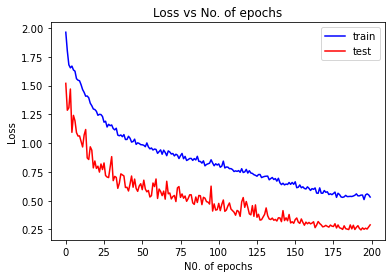

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')

plt.xlabel("N0. of epochs")
plt.ylabel("Loss")
plt.title("Loss vs No. of epochs")
plt.legend(['train', 'test'])
plt.show()

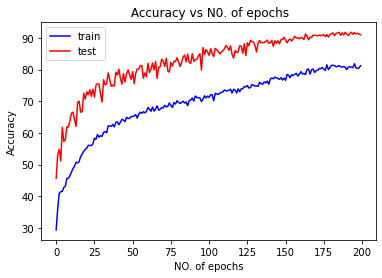

In [17]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("NO. of epochs")
plt.ylabel("Accuracy")
plt.title(" Accuracy vs N0. of epochs")
plt.legend(['train', 'test']) 
plt.show()